In [1]:
# - This script loads the WELFake dataset
# - It trains multiple traditional ML models (Logistic Regression, Linear SVM, RandomForest,
#   MultinomialNB, XGBoost, Decision Tree, KNN) and reports comparison metrics for binary settings.
# - Adjust hyperparameters or pipeline steps as needed.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report

# ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bdas2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1. LOAD DATA

In [3]:
# 1. LOAD DATA
# ============================
df = pd.read_csv("WELFake_Dataset.csv")

df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [4]:
# - Label (0 = fake and 1 = real)

In [5]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


Unnamed: 0      0
title         558
text           39
label           0
dtype: int64

### 2. EDA

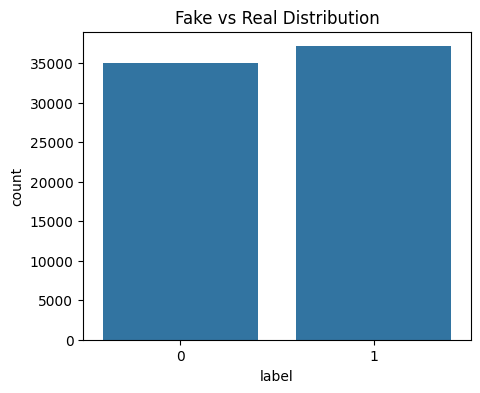

In [6]:
# 2. EDA
# ============================
# Label distribution
plt.figure(figsize=(5,4))
sns.countplot(x=df['label'])
plt.title("Fake vs Real Distribution")
plt.show()

In [7]:
print(df['label'].value_counts())
# - Label (0 = fake and 1 = real)

label
1    37106
0    35028
Name: count, dtype: int64


In [8]:
# CHECK & REMOVE DUPLICATES
# ============================
# Duplicate - title
print("Total rows before removing duplicates:", len(df))

# Check number of duplicates
duplicate_count = df.duplicated().sum()
print("Number of duplicate rows:", duplicate_count)

# Remove duplicates
df = df.drop_duplicates().reset_index(drop=True)

print("Total rows after removing duplicates:", len(df))

Total rows before removing duplicates: 72134
Number of duplicate rows: 0
Total rows after removing duplicates: 72134


In [9]:
# Duplicate - clean_text

print("Duplicates based on cleaned text column only:", df.duplicated(subset=['text']).sum())

new_df = df.drop_duplicates(subset=['text']).reset_index(drop=True)

print("After removing text duplicates:", len(new_df))

Duplicates based on cleaned text column only: 9415
After removing text duplicates: 62719


In [10]:
print(new_df['label'].value_counts())
# - Label (0 = fake and 1 = real)

label
0    34620
1    28099
Name: count, dtype: int64


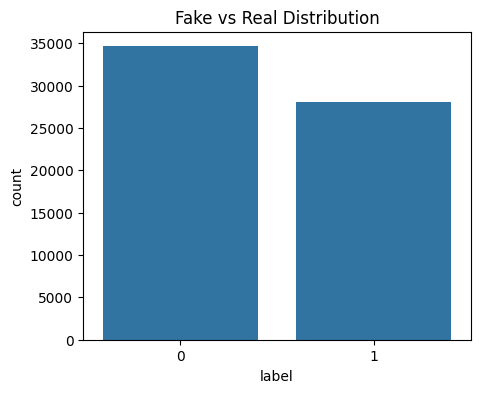

In [11]:
# Label distribution
plt.figure(figsize=(5,4))
sns.countplot(x=new_df['label'])
plt.title("Fake vs Real Distribution")
plt.show()

### 3. TEXT PREPROCESSING

In [12]:
# 3. TEXT PREPROCESSING
# ============================

# Convert all text values to string and fill NaN
new_df['text'] = new_df['text'].astype(str).fillna("")

def clean_text(text):
    text = text.lower()                              # lowercase
    text = re.sub(r'https?://\S+', '', text)         # remove links
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    text = re.sub(r'\d+', '', text)                  # remove numbers
    words = text.split()
    words = [w for w in words if w not in stop_words]  # remove stopwords
    return " ".join(words)

new_df['clean_text'] = new_df['text'].apply(clean_text)

In [13]:
new_df.head()

,Unnamed: 0,title,text,label,clean_text
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,comment expected barack obama members fyf fuky...
1,1,NaN,Did they post their votes for Hillary already?,1,post votes hillary already
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,demonstrators gathered last night exercising c...
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,dozen politically active pastors came private ...
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,rs sarmat missile dubbed satan replace ss flie...


### 4. TRAIN-TEST SPLIT

In [14]:
# 4. TRAIN-TEST SPLIT
# ============================
X_train, X_test, y_train, y_test = train_test_split(
    new_df['clean_text'], new_df['label'], test_size=0.2, random_state=42
)

### 5. TEXT VECTORISATION (TF-IDF)

In [15]:
# 5. TEXT VECTORISATION (TF-IDF)
# ============================
tfidf = TfidfVectorizer(max_features=5000)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

### 6. MODEL TRAINING & EVALUATION

In [16]:
# 6. MODEL TRAINING & EVALUATION
# ============================

from sklearn.metrics import accuracy_score, classification_report, f1_score
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss'),
    "Multinomial NB": MultinomialNB(),
    "SVM": LinearSVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier()
}

results = {"Model": [], "Accuracy": [], "F1 Score": []}

for name, model in models.items():
    print(f"\n========== Training {name} ==========\n")
    model.fit(X_train_vec, y_train)
    preds = model.predict(X_test_vec)

    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average="weighted")

    results["Model"].append(name)
    results["Accuracy"].append(acc)
    results["F1 Score"].append(f1)

    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(classification_report(y_test, preds))


========== Training Logistic Regression ==========

Accuracy: 0.9452
F1 Score: 0.9452
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      6945
           1       0.94      0.94      0.94      5599

    accuracy                           0.95     12544
   macro avg       0.94      0.94      0.94     12544
weighted avg       0.95      0.95      0.95     12544


========== Training Random Forest ==========

Accuracy: 0.9349
F1 Score: 0.9348
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      6945
           1       0.94      0.92      0.93      5599

    accuracy                           0.93     12544
   macro avg       0.94      0.93      0.93     12544
weighted avg       0.93      0.93      0.93     12544


========== Training XGBoost ==========

Accuracy: 0.9562
F1 Score: 0.9562
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     

C:\Users\bdas2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy: 0.9471
F1 Score: 0.9471
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      6945
           1       0.94      0.94      0.94      5599

    accuracy                           0.95     12544
   macro avg       0.95      0.95      0.95     12544
weighted avg       0.95      0.95      0.95     12544


========== Training Decision Tree ==========

Accuracy: 0.8990
F1 Score: 0.8991
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      6945
           1       0.88      0.89      0.89      5599

    accuracy                           0.90     12544
   macro avg       0.90      0.90      0.90     12544
weighted avg       0.90      0.90      0.90     12544


========== Training KNN ==========

Accuracy: 0.6264
F1 Score: 0.5983
              precision    recall  f1-score   support

           0       0.90      0.37      0.52      6945
           1       0.55      0.95      0.69      55

### 7. Comparison Report

In [17]:
# 7. RESULTS COMPARISON TABLE
# ============================
comparison_df = pd.DataFrame(results)
print("\n\n========== MODEL COMPARISON ==========\n")
print(comparison_df.sort_values(by="Accuracy", ascending=False))



========== MODEL COMPARISON ==========

                 Model  Accuracy  F1 Score
2              XGBoost  0.956154  0.956197
4                  SVM  0.947146  0.947135
0  Logistic Regression  0.945233  0.945234
1        Random Forest  0.934869  0.934789
5        Decision Tree  0.898996  0.899056
3       Multinomial NB  0.839286  0.839437
6                  KNN  0.626435  0.598343


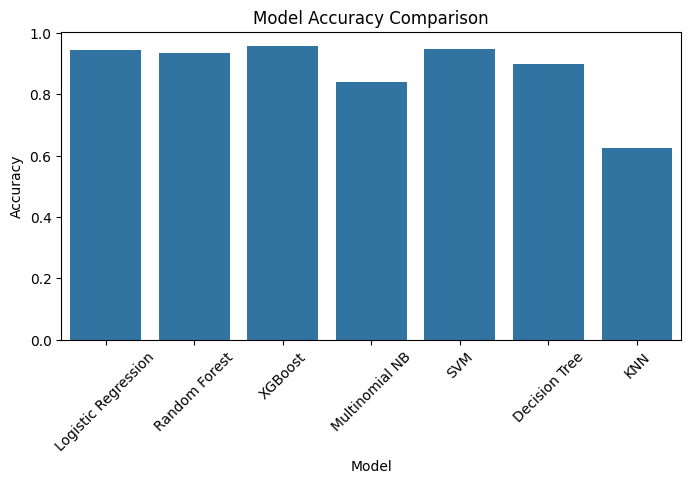

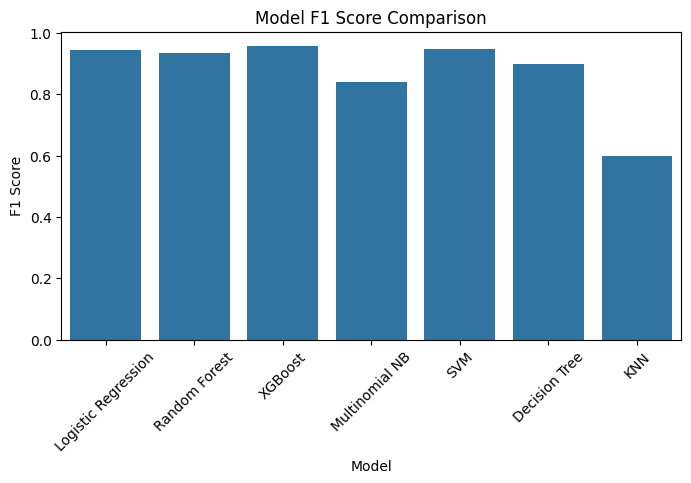

In [18]:
# 8. BAR CHART OF RESULTS
# ============================
plt.figure(figsize=(8,4))
sns.barplot(x="Model", y="Accuracy", data=comparison_df)
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8,4))
sns.barplot(x="Model", y="F1 Score", data=comparison_df)
plt.title("Model F1 Score Comparison")
plt.xticks(rotation=45)
plt.show()